In [3]:
import cufflinks as cf
import numpy as np
import pandas as pd

cf.go_offline()

In [7]:
def get_data_V2(category='confirmed'):
    df = (
        pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{category}_global.csv')
        .rename(columns={'Province/State': 'state', 'Country/Region': 'country', 'Lat': 'latitude', 'Long': 'long'})
        .set_index(['state', 'country'])
        .drop(columns=['latitude', 'long'])
    )
    df.columns = [pd.Timestamp(col) for col in df.columns]
    df = df.reset_index().drop(columns=['state']).groupby('country').sum().transpose()
    df.index.name = 'date'
    df.columns = list(df.columns)

    return df

In [24]:
def get_globe(df, name, threshold=None):
    globe = df.drop(columns=['China']).sum(axis=1)
    if threshold:
        globe[globe<threshold]=np.nan
    globe = globe.apply(np.log)
    globe.name=name
    globe = globe.dropna().reset_index()
    return globe

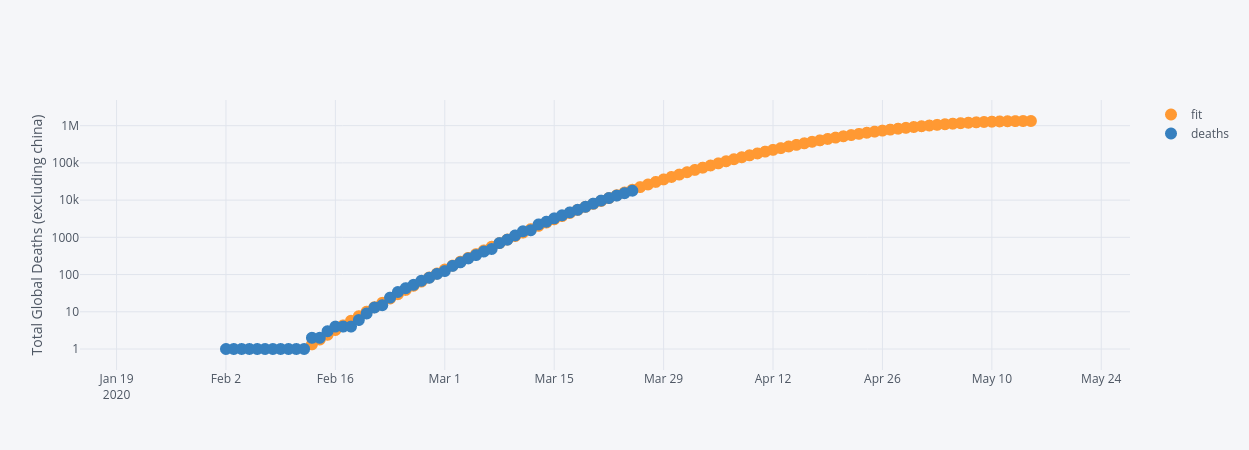

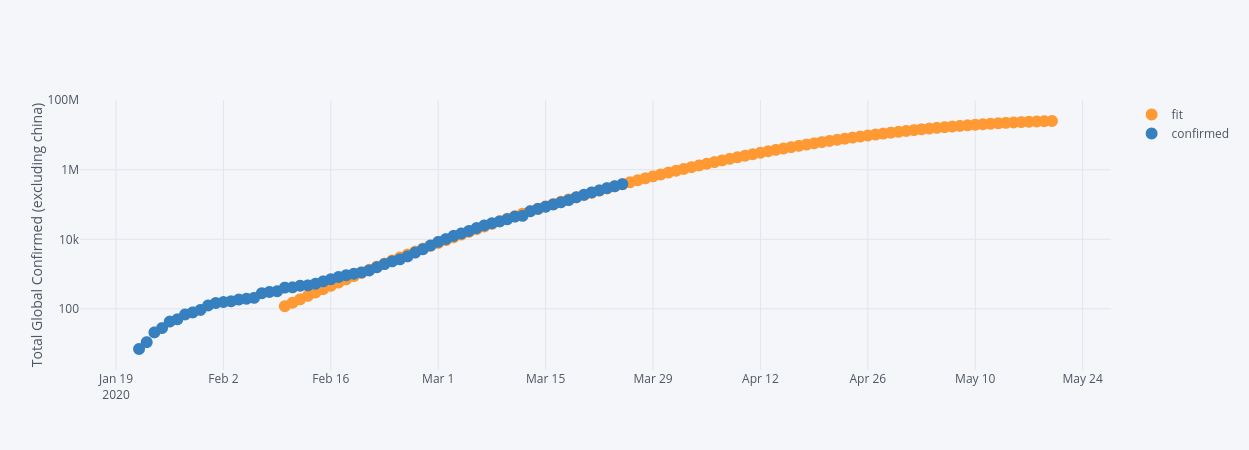

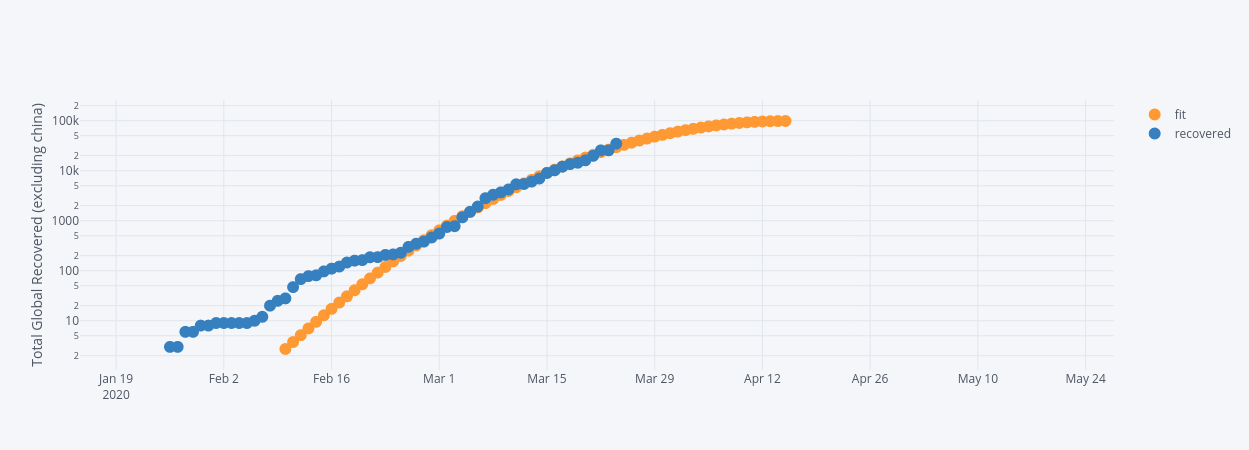

In [31]:
category = 'deaths'
threshold_for_model = {'recovered': 300, 'confirmed': 1000, 'deaths': 10}

def generate_model(category):
    df = get_data_V2(category)
    globe = get_globe(df, category, threshold=threshold_for_model[category])
    x = globe['date'].astype(int)
    c, b, a = np.polyfit(x, globe[category], 2)
    x = pd.Series(pd.date_range('2020-02-10', '2020-05-20')).astype(int)
    fit = a + b*x + c*x*x
    extra = pd.DataFrame(data=fit, columns=['fit'])
    extra['date'] = pd.to_datetime(x)
    extra = extra.set_index('date')

    globe = get_globe(df, category)
    fit = pd.concat((globe.set_index('date'), extra), axis=1)
    fit.loc[(fit<0)['fit'], 'fit'] = np.nan
    fit.loc[(fit.diff()<0)['fit'], 'fit'] = np.nan
    fit.apply(np.exp)[['fit', category]].iplot(logy=True, yTitle=f'Total Global {category.capitalize()} (excluding china)', mode='markers')
    
generate_model('deaths')
generate_model('confirmed')
generate_model('recovered')